In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

import pennylane as qml
from pennylane.operation import Operation

In [2]:
def Avg1stFP(dA, dB, t):
    dA2 = dA ** 2.0
    F_haar = 1. / binom(dA, dA - 1)
    res = F_haar * dA2 * (dB + 1) / (dA2 * dB + 1)
    res += (dA - 1) * (dA * dB - 1) / (dA2 * dB + 1) * \
        ((dA2 - 1) * dB / (dA2 * dB ** 2. - 1)) ** t

    return res

## 1 Qubit

In [3]:
class Gen2QGate(Operation):
    num_wires = 2
    grad_method = None

    def __init__(self, weights, wires, id=None):
        super().__init__(weights, wires=wires, id=id)

    @property
    def num_params(self):
        return 1

    @staticmethod
    def compute_decomposition(weights, wires):
        wires = qml.wires.Wires(wires)
        op_list = []

        op_list.append(qml.RZ(weights[0], wires=wires[0]))
        op_list.append(qml.RY(weights[1], wires=wires[0]))
        op_list.append(qml.RZ(weights[2], wires=wires[0]))

        op_list.append(qml.RZ(weights[3], wires=wires[1]))
        op_list.append(qml.RY(weights[4], wires=wires[1]))
        op_list.append(qml.RZ(weights[5], wires=wires[1]))

        op_list.append(qml.CNOT(wires=wires))

        op_list.append(qml.RY(weights[6], wires=wires[0]))
        op_list.append(qml.RZ(weights[7], wires=wires[1]))

        op_list.append(qml.CNOT(wires=wires[::-1]))

        op_list.append(qml.RY(weights[8], wires=wires[0]))

        op_list.append(qml.CNOT(wires=wires))

        op_list.append(qml.RZ(weights[9], wires=wires[0]))
        op_list.append(qml.RY(weights[10], wires=wires[0]))
        op_list.append(qml.RZ(weights[11], wires=wires[0]))

        op_list.append(qml.RZ(weights[12], wires=wires[1]))
        op_list.append(qml.RY(weights[13], wires=wires[1]))
        op_list.append(qml.RZ(weights[14], wires=wires[1]))

        return op_list

In [4]:
n_wires = 4
dev = qml.device('default.qubit', wires=n_wires, shots=1000)

@qml.qnode(dev)
def qml_circuit(params):
    Gen2QGate(weights=params[0], wires=[0, 1])
    Gen2QGate(weights=params[1], wires=[0, 2])
    Gen2QGate(weights=params[2], wires=[0, 3])

    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))

C:\Users\franc\AppData\Local\Temp\ipykernel_34912\1352482566.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


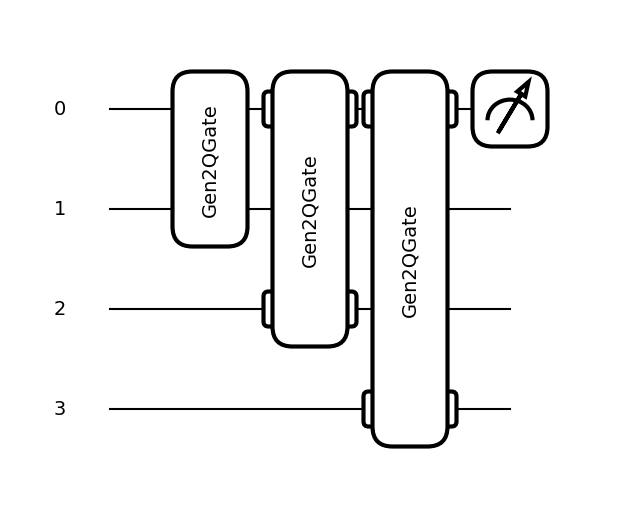

In [5]:
weights = np.random.uniform(0, 4 * np.pi, (3, 15))
fig, ax = qml.draw_mpl(qml_circuit)(weights)
fig.show()

In [6]:
bloch_vec = []
for _ in range(1000):
    weights = np.random.uniform(0, 4 * np.pi, (3, 15))
    bloch_vec.append(qml_circuit(weights))

bloch_vec = np.array(bloch_vec)
purities = (1. + np.sum(bloch_vec ** 2., axis=1)) / 2.

In [7]:
[purities.mean(), purities.std()]

[0.7268339620000001, 0.12586742531267794]

In [8]:
# target
Avg1stFP(2, 2, 3)

0.688

C:\Users\franc\AppData\Local\Temp\ipykernel_34912\3465295749.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


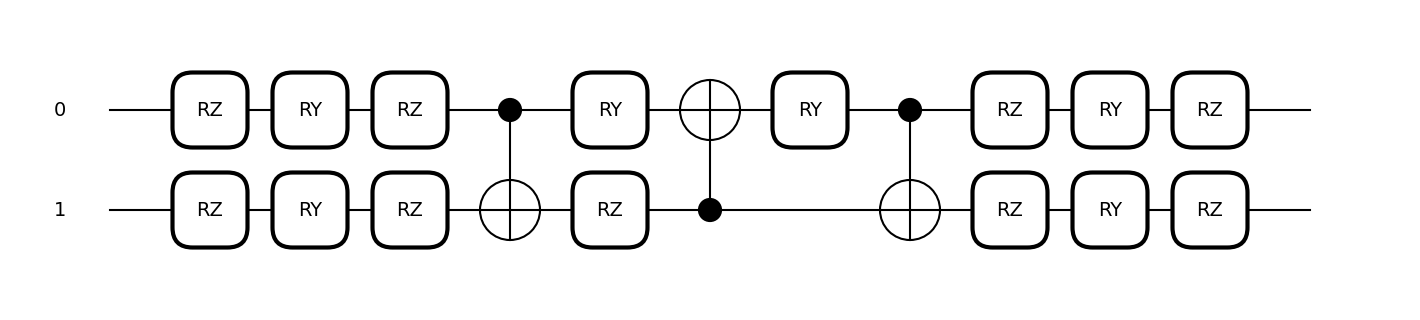

In [9]:
# for plot use
@qml.qnode(dev)
def gen2layer(weights):
    qml.RZ(weights[0], wires=0)
    qml.RY(weights[1], wires=0)
    qml.RZ(weights[2], wires=0)

    qml.RZ(weights[3], wires=1)
    qml.RY(weights[4], wires=1)
    qml.RZ(weights[5], wires=1)

    qml.CNOT(wires=[0, 1])

    qml.RY(weights[6], wires=0)
    qml.RZ(weights[7], wires=1)

    qml.CNOT(wires=[1, 0])

    qml.RY(weights[8], wires=0)

    qml.CNOT(wires=[0, 1])

    qml.RZ(weights[9], wires=0)
    qml.RY(weights[10], wires=0)
    qml.RZ(weights[11], wires=0)

    qml.RZ(weights[12], wires=1)
    qml.RY(weights[13], wires=1)
    qml.RZ(weights[14], wires=1)

    return 0


weights = np.random.uniform(-np.pi, np.pi, (15))
fig, ax = qml.draw_mpl(gen2layer)(weights)
fig.show()

## HEA circuit, 2 Qubits

In [10]:
def get_purity(r_vals):
    return np.sum(np.array(r_vals) ** 2.) / 4.
    
def get_density(r_vals):
    paulis = [qml.Identity, qml.PauliX, qml.PauliY, qml.PauliZ]

    res = np.zeros(shape=(4, 4)).astype(complex)
    for i in range(4):
        for j in range(4):
            res += r_vals[i, j] * qml.matrix(paulis[i](0) @ paulis[j](1)).astype(complex)

    res /= 4.

    return res

In [11]:
n_wires = 5
dev = qml.device('default.qubit', wires=n_wires, shots=1000)


@qml.qnode(dev)
def HEA_circuit(params):
    paulis = [qml.Identity, qml.PauliX, qml.PauliY, qml.PauliZ]
    depth = params.shape[1]
    for i in range(3):
        for l in range(depth):
            qml.RY(params[i, l, 0], wires=0)
            qml.RZ(params[i, l, 0], wires=0)
            qml.RY(params[i, l, 1], wires=1)
            qml.RZ(params[i, l, 1], wires=1)
            qml.RY(params[i, l, 2], wires=i + 2)
            qml.RZ(params[i, l, 2], wires=i + 2)

            qml.CNOT(wires=[0, i + 2])
            qml.CNOT(wires=[1, i + 2])

    return [qml.expval(paulis[i](0) @ paulis[j](1)) for i in range(4) for j in range(4)]

C:\Users\franc\AppData\Local\Temp\ipykernel_34912\1911597336.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


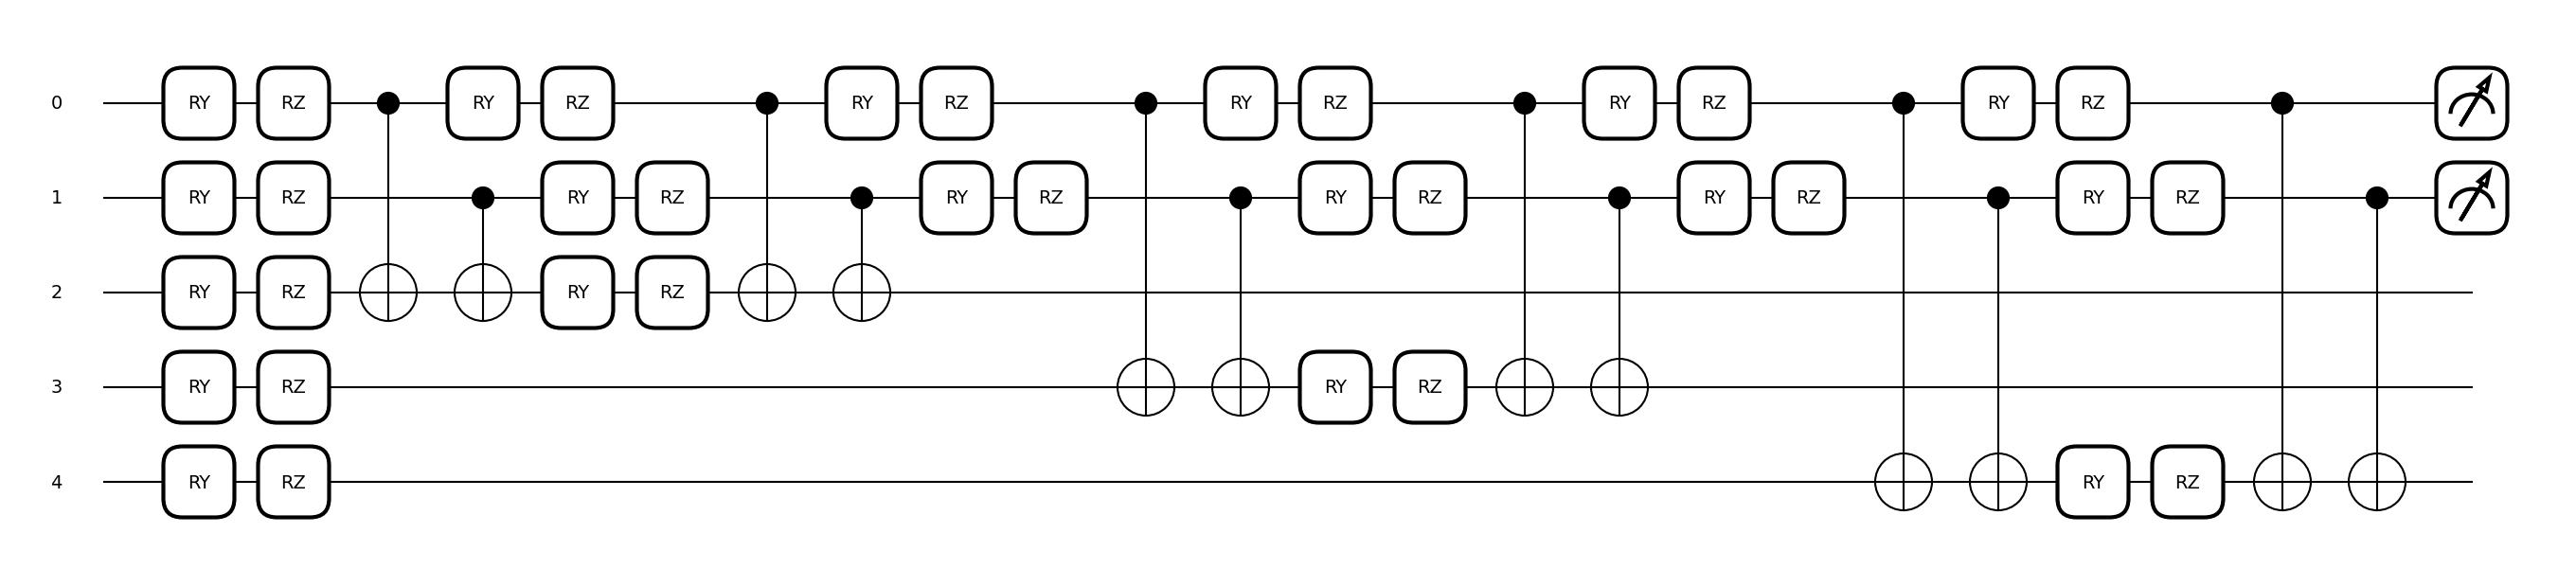

In [12]:
weights = np.random.uniform(0, 4. * np.pi, (5, 2, 3))
fig, ax = qml.draw_mpl(HEA_circuit)(weights)
fig.show()

In [13]:
purities = []
for _ in range(1000):
    weights = np.random.uniform(0, 4. *np.pi, (5, 5, 3))
    r_vals = np.array(HEA_circuit(weights)).reshape(4, 4)
    purities.append(get_purity(r_vals))

purities = np.array(purities)

In [14]:
[purities.mean(), purities.std()]

[0.429814568, 0.0629348025848606]

In [15]:
# target
Avg1stFP(4, 2, 3)

0.4323507180650038